# Modeling: Aspect-Based Sentiment Analysis
## BERT

## 1. Library Importation

In [1]:
#Data manipulation and visualization packages
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

#Modeling packages
import torch
from tqdm.auto import tqdm
import pytorch_lightning as pl
from torchmetrics import Accuracy, F1, AUROC
from torch.utils.data import Dataset, DataLoader
from pytorch_lightning.loggers import TensorBoardLogger
from pytorch_lightning.callbacks import ModelCheckpoint, EarlyStopping
from transformers import BertTokenizerFast as BertTokenizer, BertModel, AdamW, get_linear_schedule_with_warmup

#Model evaluation and metrics
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, multilabel_confusion_matrix

#Set seed
RANDOM_SEED = 123
pl.seed_everything(RANDOM_SEED)

Global seed set to 123


123

## 2. Loading the data

In [2]:
#Load the dataframe with punctuated tweets. We will replace the tweets in the dataset below with this
df_with_punct = pd.read_csv("../data/processed/sample_encoded_and_cleaned.csv")
print(df_with_punct.shape)
df_with_punct.head()

(377, 6)


,ISP_Name,Time,Text,Source,sentiment,label
0,sprectranet,2020-02-04 18:30:35+00:00,my family used my spectranet and they don't wa...,Twitter for Android,Neutral,1
1,sprectranet,2019-06-19 04:59:49,spectranet_ng how can i get the freedom mifi i...,Twitter for iPhone,Neutral,1
2,sprectranet,2020-03-30 07:57:38+00:00,drolufunmilayo iconic_remi spectranet_ng,Twitter for iPhone,Neutral,1
3,sprectranet,2020-12-31 21:07:52+00:00,spectranet_ng your response just proves how ho...,Twitter for Android,Negative,0
4,sprectranet,2020-09-03 23:09:09+00:00,"spectranet is just the worse tbh, i can't even...",Twitter for iPhone,Negative,0


In [3]:
#Load the corresponding aspect annotated data with the text cleaned with punctuation removal
df = pd.read_csv("../data/processed/absa_labelled.csv")
print(df.shape)
df.head()

(377, 3)


,Tweets,Aspects,Sentiment
0,my family used my spectranet and they dont wan...,NaN,NaN
1,spectranetng how can i get the freedom mifi in...,NaN,NaN
2,drolufunmilayo iconicremi spectranetng,NaN,NaN
3,spectranetng your response just proves how hor...,['customer service'],['Negative']
4,spectranet is just the worse tbh i cant even w...,['speed'],['Negative']


In [4]:
#Create new dataset with the punctuated tweets and the aspects annotated
aspect_df = pd.concat([df_with_punct[['Text']],
                       df[['Aspects','Sentiment']]],axis=1)
aspect_df.head()

,Text,Aspects,Sentiment
0,my family used my spectranet and they don't wa...,NaN,NaN
1,spectranet_ng how can i get the freedom mifi i...,NaN,NaN
2,drolufunmilayo iconic_remi spectranet_ng,NaN,NaN
3,spectranet_ng your response just proves how ho...,['customer service'],['Negative']
4,"spectranet is just the worse tbh, i can't even...",['speed'],['Negative']


In [5]:
#Save the new dataframe for future reference
aspect_df.to_csv("../data/processed/absa_text_with_punct.csv", index=False)

## 3. Reformat the data

### a. Convert lists from string format to list

In [6]:
#Convert Aspects column
aspect_df.Aspects = aspect_df.Aspects.apply(lambda x: eval(x) if (pd.notnull(x)) else x)

#Convert Sentiment column
aspect_df.Sentiment = aspect_df.Sentiment.apply(lambda x: eval(x) if (pd.notnull(x)) else x)

#Make a copy of the dataframe
processed_aspect_df = aspect_df.copy()

#Quick preview
processed_aspect_df.head()

,Text,Aspects,Sentiment
0,my family used my spectranet and they don't wa...,NaN,NaN
1,spectranet_ng how can i get the freedom mifi i...,NaN,NaN
2,drolufunmilayo iconic_remi spectranet_ng,NaN,NaN
3,spectranet_ng your response just proves how ho...,[customer service],[Negative]
4,"spectranet is just the worse tbh, i can't even...",[speed],[Negative]


### b. Fill NaNs with [None]

In [7]:
processed_aspect_df = processed_aspect_df.apply(lambda s: s.fillna({i: [None] for i in df.index}))
processed_aspect_df.head()

,Text,Aspects,Sentiment
0,my family used my spectranet and they don't wa...,[None],[None]
1,spectranet_ng how can i get the freedom mifi i...,[None],[None]
2,drolufunmilayo iconic_remi spectranet_ng,[None],[None]
3,spectranet_ng your response just proves how ho...,[customer service],[Negative]
4,"spectranet is just the worse tbh, i can't even...",[speed],[Negative]


### b. Binarizing the aspects

In [8]:
#List aspects determined during the annotation phase
#Note: This might not be exhaustive! But it should cover most cases. It is also subjective!
#Also using synonyms of these words will likely yield different results
ASPECTS = ['cost','speed','reliability','coverage', 'customer service', 'trustworthiness']

#Iterate through all the aspects and if the aspect is not in the tweet, record 0 else record 1
for aspect in ASPECTS[::-1]:
    processed_aspect_df.insert(1,aspect,processed_aspect_df.Aspects.apply(lambda x: 1 if aspect in x else 0))
    
#Drop the Aspects column
processed_aspect_df.drop(columns=['Aspects'] , inplace=True)

#Quick preview
processed_aspect_df.head()

,Text,cost,speed,reliability,coverage,customer service,trustworthiness,Sentiment
0,my family used my spectranet and they don't wa...,0,0,0,0,0,0,[None]
1,spectranet_ng how can i get the freedom mifi i...,0,0,0,0,0,0,[None]
2,drolufunmilayo iconic_remi spectranet_ng,0,0,0,0,0,0,[None]
3,spectranet_ng your response just proves how ho...,0,0,0,0,1,0,[Negative]
4,"spectranet is just the worse tbh, i can't even...",0,1,0,0,0,0,[Negative]


In [9]:
#Save the binarized dataframe
processed_aspect_df.to_csv("../data/processed/absa_binarized.csv",index=False)

## 4. Quick EDA

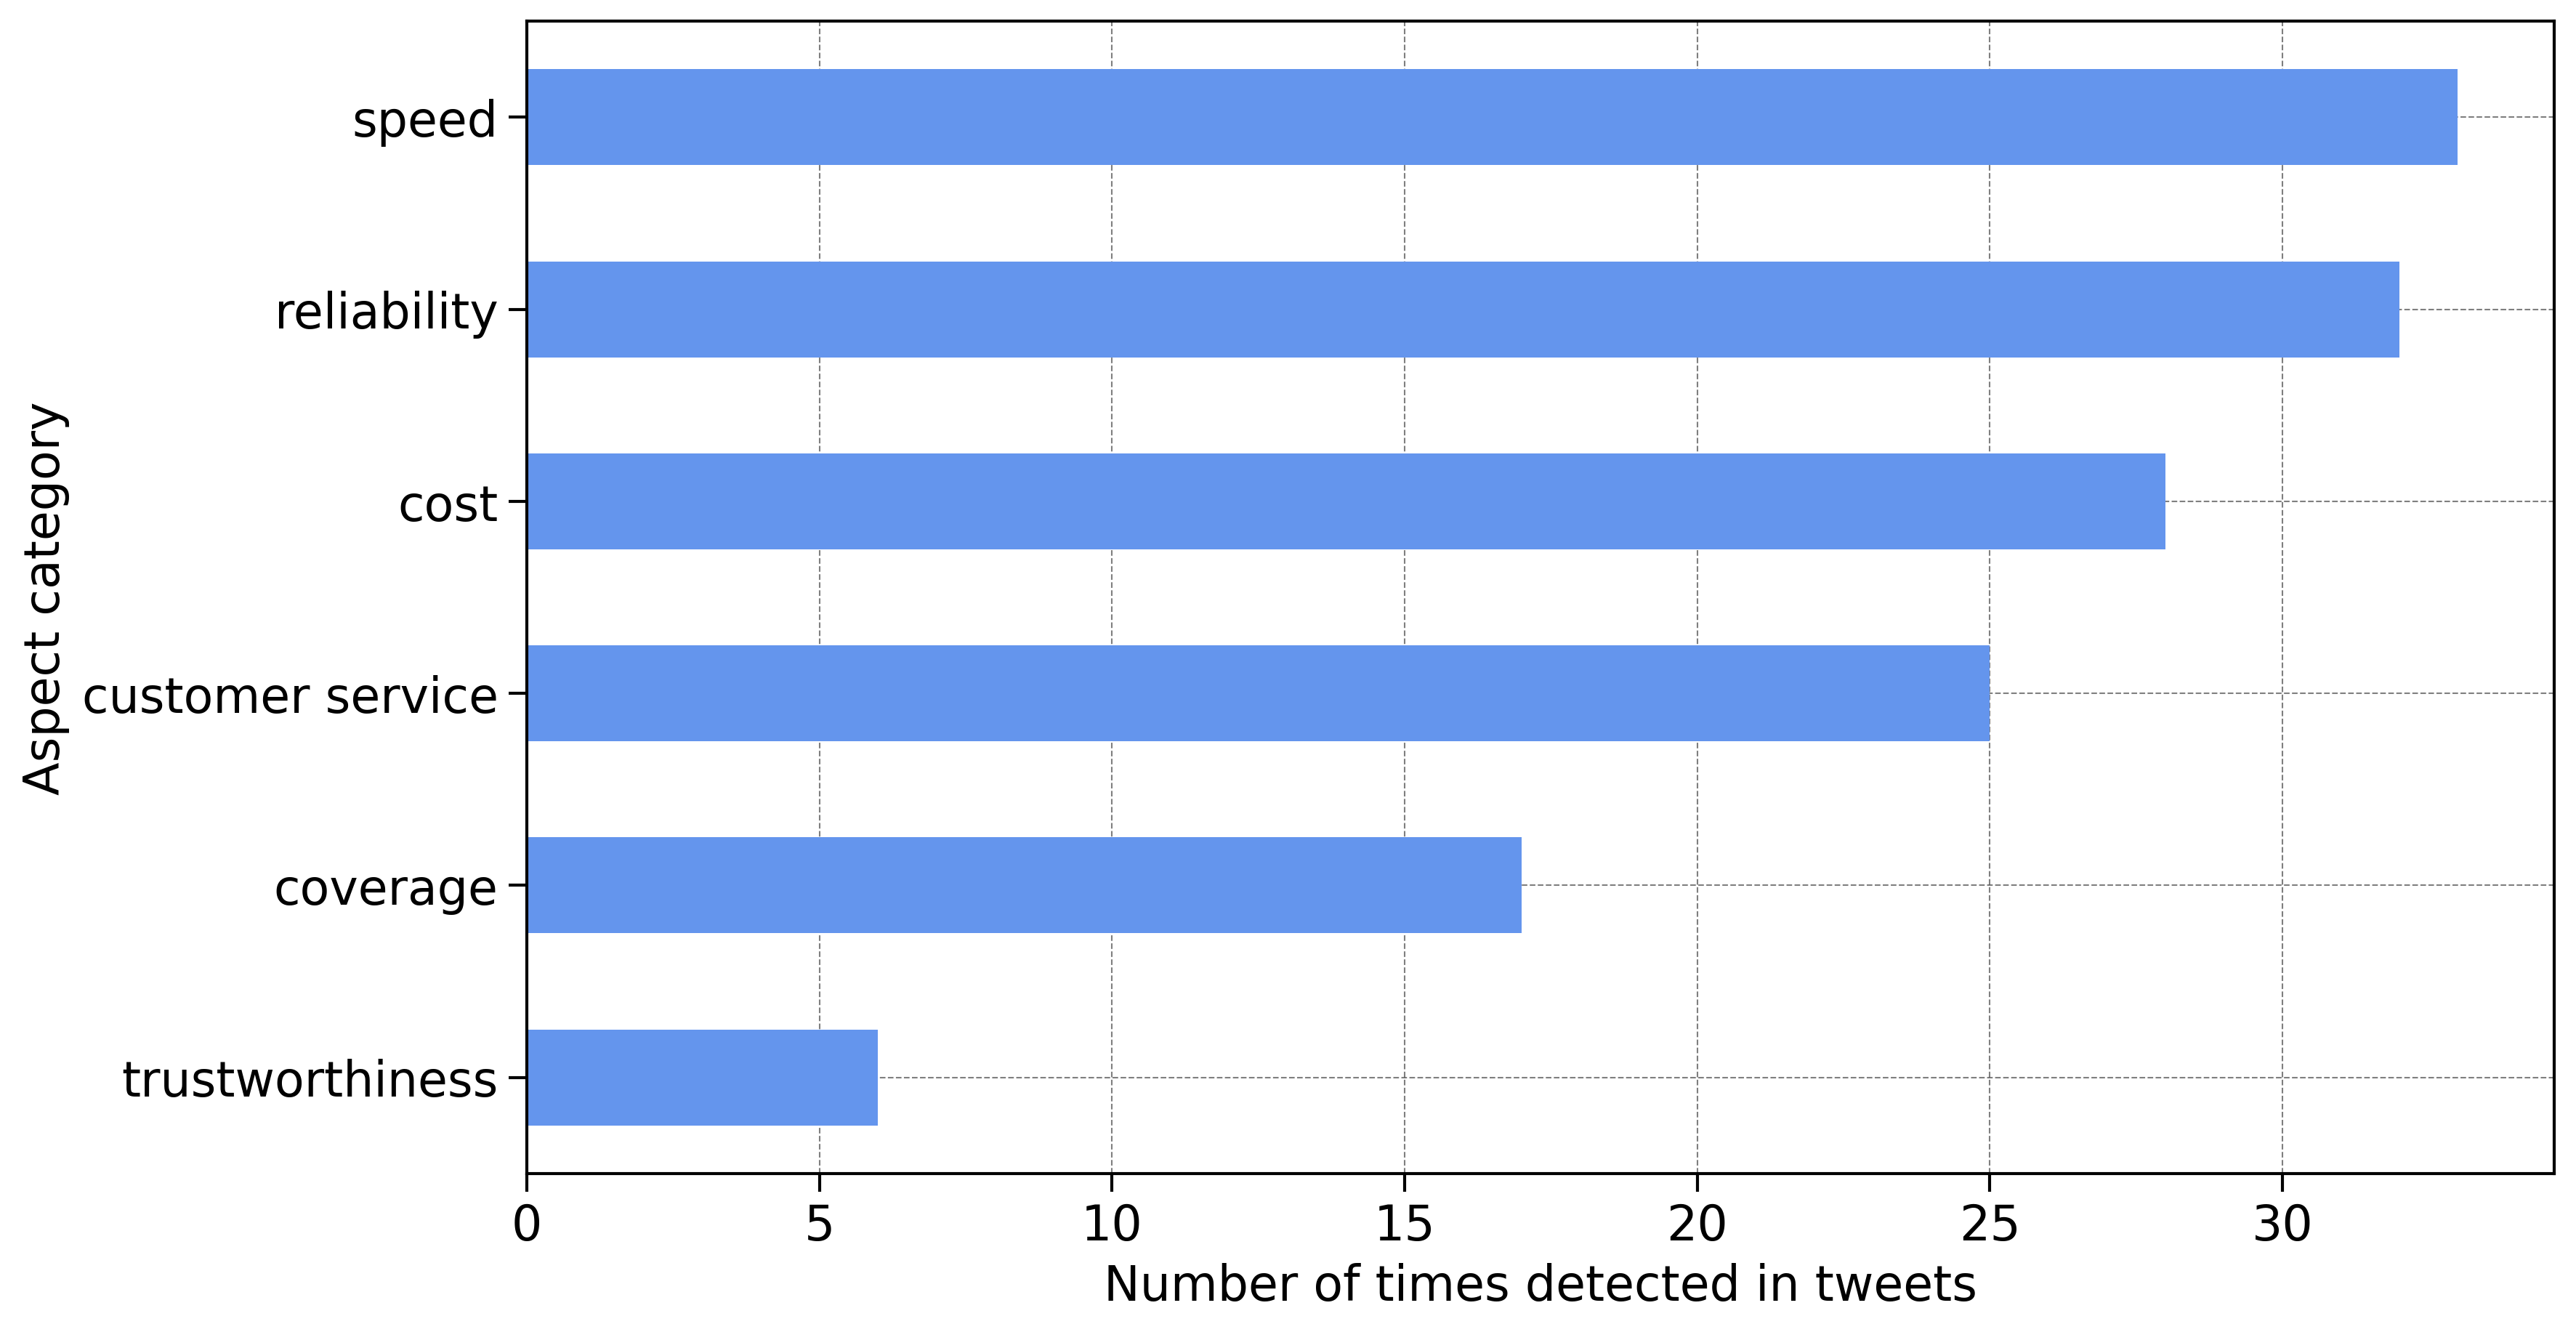

In [10]:
with plt.style.context(['notebook','no-latex','grid']):
    plt.figure(figsize = (12,7), dpi=300)
    processed_aspect_df[ASPECTS].sum().sort_values()\
                                            .plot(kind = "barh", color = 'cornflowerblue')\
                                            .set(xlabel = "Number of times detected in tweets",
                                                ylabel = "Aspect category")
                        
    plt.show()

From the above, we see that the data is quite imbalanced. Trustworthiness is especially important to point out. It doesn't stop there though, we also have imbalance along the aspect detected/ no aspect detected dimension:

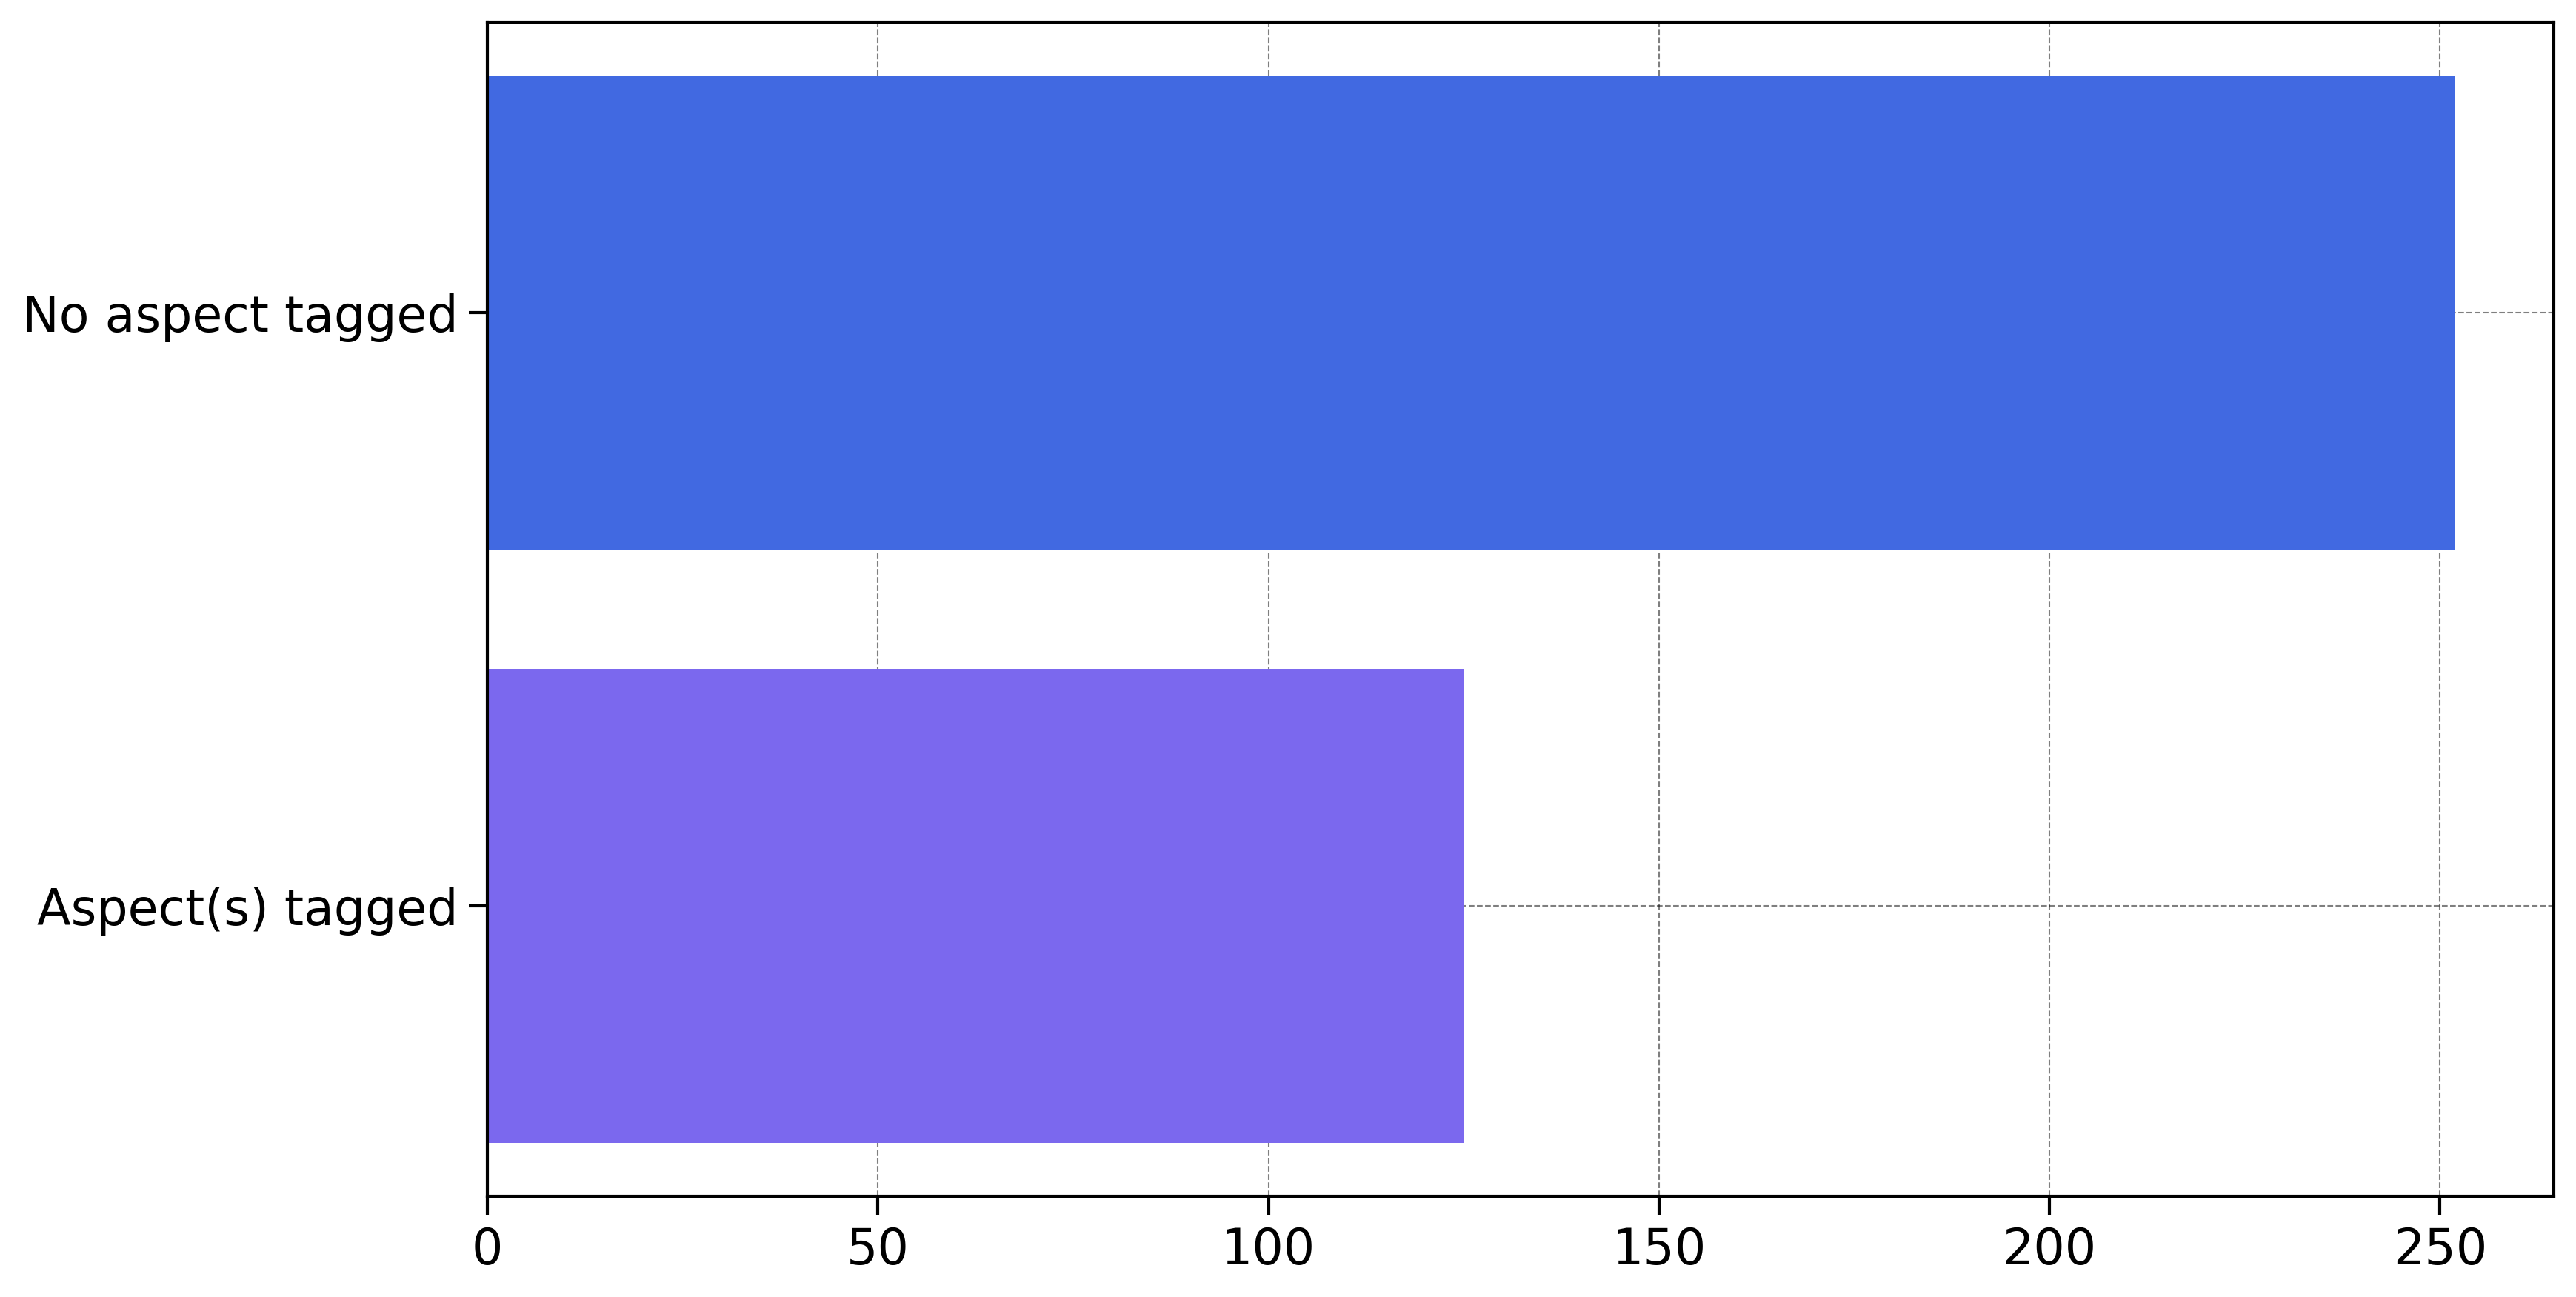

In [11]:
#Get the rows with aspects tagged and no aspects tagged
aspects_tagged = processed_aspect_df[processed_aspect_df[ASPECTS].sum(axis=1) > 0]
no_aspects_tagged = processed_aspect_df[processed_aspect_df[ASPECTS].sum(axis=1) == 0]

with plt.style.context(['notebook','no-latex','grid']):
    plt.figure(figsize = (12,7), dpi=300)
    plt.barh(['Aspect(s) tagged','No aspect tagged'],
             [len(aspects_tagged),len(no_aspects_tagged)],color=['mediumslateblue','royalblue'])

# pd.DataFrame(dict(
#   aspects=[len(aspects_tagged)],
#   no_aspects=[len(train_clean)]
# )).plot(kind='barh');

Hence, I oversample, but first I split to train-validation-test, before the eventual oversampling of the training set

## 5. Split data into training, validation and test set

### a. Split to training and test set

In [12]:
#Split the data 80:20 (training and test)
train_df, test_df = train_test_split(processed_aspect_df,test_size=0.20, 
                                     stratify = processed_aspect_df[['trustworthiness','customer service']])
print(f"Train size: {train_df.shape}", f"Test size: {test_df.shape}")

Train size: (301, 8) Test size: (76, 8)


### b. Split training set to training and validation set

In [13]:
train_df, val_df = train_test_split(train_df,test_size=0.25,
                                    stratify = train_df[['trustworthiness','customer service']])
print(f"Train size: {train_df.shape}", f"Validation size: {val_df.shape}")

Train size: (225, 8) Validation size: (76, 8)


### c. Oversample tweets with aspects in the training set

In [15]:
#Get rows with atleast one aspect tagged and rows with no aspect tagged
train_aspects_tagged = train_df[train_df[ASPECTS].sum(axis=1) > 0]
train_no_aspects = train_df[train_df[ASPECTS].sum(axis=1) == 0]

#Oversample the rows with tagged aspects
train_df = pd.concat([
  train_no_aspects,
  train_aspects_tagged.sample(len(train_no_aspects), replace=True)
])

#Check that the counts are balanced now
print(f"No aspects count: {len(train_df[train_df[ASPECTS].sum(axis=1) == 0])}.",
      f"Aspects count: {len(train_df[train_df[ASPECTS].sum(axis=1) > 0])}")

print(f"Train size: {train_df.shape}")

No aspects count: 147. Aspects count: 147
Train size: (294, 8)


### d. Check to see that all the sets have all the aspect categories

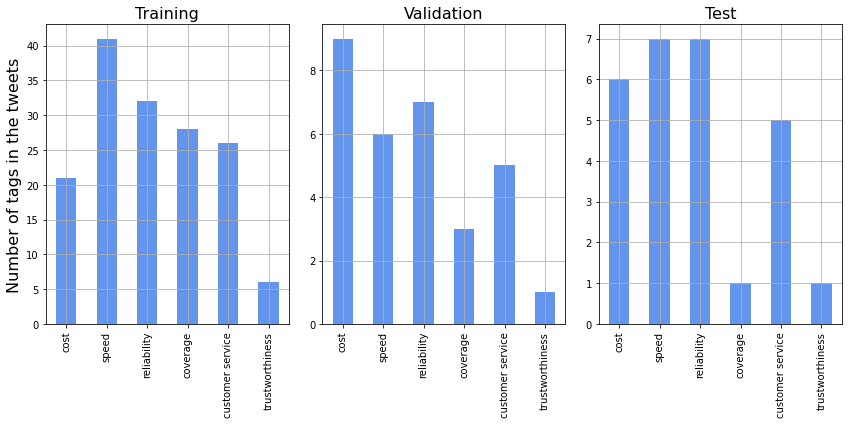

In [16]:
df_sets = [('Training',train_df),('Validation', val_df),('Test',test_df)]
    
plt.figure(figsize = (12,6))
for idx,df in enumerate(df_sets):
    
    plt.subplot(1,3,idx+1)
    plt.tight_layout()

    with plt.style.context(['notebook','no-latex','grid']):
        
        plt.title(df[0])
        df[1][ASPECTS].sum().plot(kind = "bar", color = 'cornflowerblue')
        plt.xticks(rotation=90)
        
        if idx == 0:
            plt.ylabel('Number of tags in the tweets', fontsize=16)
        
    
plt.show()
        

## 6. Modeling - Aspect Extraction

### a. Load the tokenizer and the BERTweet model

In [17]:
#Specify the BERT model to use
BERT_MODEL_NAME = 'bert-base-cased'

#Load BerTweet tokenizer
TOKENIZER = BertTokenizer.from_pretrained(BERT_MODEL_NAME)

#Load the BERTweet model
BERT_MODEL = BertModel.from_pretrained(BERT_MODEL_NAME, from_tf = True, return_dict=True)

2021-11-25 10:18:11.189951: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
All TF 2.0 model weights were used when initializing BertModel.

All the weights of BertModel were initialized from the TF 2.0 model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use BertModel for predictions without further training.


### b. Prepare the training, validation, and test sets

In [18]:
TRAIN_BATCH_SIZE = 16
TEST_BATCH_SIZE = 8

In [19]:
class Generate_PyTorch_Dataset(torch.utils.data.Dataset):

    def __init__(self, dataframe, tokenizer):
        self.dataframe  = dataframe
        self.tokenizer  = tokenizer
        self.max_len    = tokenizer.model_max_length
  
    def __len__(self):
        return len(self.dataframe)
  
    def __getitem__(self, idx):
        
        #Get each row of the dataframe
        data_row = self.dataframe.iloc[idx]
        
        #Get the tweet
        text = str(data_row.Text)
        
        #Get the aspect labels
        labels = data_row[ASPECTS]
        
        #Encode the tweet
        encoded_text = self.tokenizer.encode_plus(
            text,
            add_special_tokens    = True,
            truncation            = True,
            return_attention_mask = True,
            return_token_type_ids = False,
            return_length         = True,
            max_length            = self.max_len,
            return_tensors        = 'pt',
            padding               = "max_length"
        )
        
        
        return {
            'input_ids': encoded_text['input_ids'].flatten(),
            'attention_mask': encoded_text['attention_mask'].flatten(),
            'labels': torch.tensor(labels, dtype=torch.float)
        }
    

In [20]:
class PyTorchDataModule(pl.LightningDataModule):
    
    def __init__(self, train_df, val_df, test_df, tokenizer, train_batch_size=16, test_batch_size=8):
        
        super().__init__()
        self.train_df = train_df
        self.val_df = train_df
        self.test_df = test_df
        self.tokenizer = tokenizer
        self.train_batch_size = train_batch_size
        self.test_batch_size = test_batch_size
        self.max_len = self.tokenizer.model_max_length
        
    def setup(self):
        
        """
        Setup the training, validation and test sets by converting them to Pytorch datasets
        """
        
        self.train_dataset = Generate_PyTorch_Dataset(self.train_df,self.tokenizer)
        self.val_dataset = Generate_PyTorch_Dataset(self.val_df,self.tokenizer)
        self.test_dataset = Generate_PyTorch_Dataset(self.test_df,self.tokenizer)
        
        
    def train_dataloader(self):
        
        """
        Training set dataloader
        """
        
        return DataLoader(self.train_dataset,
                          batch_size  = self.train_batch_size,
                          shuffle     = True, 
                          num_workers = 2)
         
    def val_dataloader(self):
        
        """
        Validation set dataloader
        """
        
        return DataLoader(self.val_dataset, batch_size = self.test_batch_size, num_workers=2)
        
    def test_dataloader(self):
        
        """
        Test set dataloader
        """
        
        return DataLoader(self.test_dataset, batch_size = self.test_batch_size, num_workers=2)
        

In [21]:
#Instantiate and set up the data_module
data_module = PyTorchDataModule(train_df,val_df,test_df,TOKENIZER, TRAIN_BATCH_SIZE, TEST_BATCH_SIZE)
data_module.setup()

### c. Define the model

In [22]:
class ISP_TweetAspectClassifier(pl.LightningModule):
    
    #Set the aspect classifier
    def __init__(self, n_classes=6, n_training_steps=None, n_warmup_steps=None, lr=2e-5):
        super().__init__()
        self.bert = BERT_MODEL
        self.classifier = torch.nn.Linear(self.bert.config.hidden_size, n_classes)
        self.n_training_steps = n_training_steps
        self.n_warmup_steps = n_warmup_steps
        self.lr = lr
        self.criterion = torch.nn.BCELoss()
        
    def forward(self, input_ids, attention_mask, labels = None):
        output = self.bert(input_ids, attention_mask=attention_mask)
        output = self.classifier(output.pooler_output)
        output = torch.sigmoid(output)
        
        loss = 0
        
        if labels is not None:
            loss = self.criterion(output, labels)
            
        return loss, output
    
    def training_step(self, batch, batch_idx):
        
        input_ids = batch["input_ids"]
        attention_mask = batch["attention_mask"]
        labels = batch["labels"]
        
        loss, outputs = self(input_ids, attention_mask, labels)
        self.log("train_loss", loss, prog_bar=True, logger=True)
        
        return {"loss": loss, "predictions": outputs.detach(), "labels": labels}
    
    def validation_step(self, batch, batch_idx):
        input_ids = batch["input_ids"]
        attention_mask = batch["attention_mask"]
        labels = batch["labels"]
        
        loss, outputs = self(input_ids, attention_mask,labels)
        self.log("val_loss", loss, prog_bar=True, logger=True)
        
        return loss
    
    
    def test_step(self, batch, batch_idx):
        input_ids = batch["input_ids"]
        attention_mask = batch["attention_mask"]
        labels = batch["labels"]
        
        loss, outputs = self(input_ids, attention_mask, labels)
        self.log("test_loss", loss, prog_bar=True, logger=True)
        
        return loss
    
    
    def training_epoch_end(self, outputs):
        
        #List to store the true labels and the model's predictions
        labels = []
        predictions = []
        
        #Iterate through all the outputs and get the true vs. predicted label
        for output in outputs:
            
            for label in output["labels"].detach().cpu():
                labels.append(label)
            for pred in output["predictions"].detach().cpu():
                predictions.append(pred)
        
        #Stack the tensors
        labels = torch.stack(labels).int()
        predictions = torch.stack(predictions)
        
        #Record the AUROC for each aspect after each training epoch
        for idx, name in enumerate(ASPECTS):
            metric = AUROC()
            class_roc_auc = metric(predictions[:,idx], labels[:,idx])
            self.logger.experiment.add_scalar(f"{name}_roc_auc/Train", class_roc_auc, self.current_epoch)
   
    
    def configure_optimizers(self):
        
        optimizer = AdamW(self.parameters(), lr = self.lr)
        
        scheduler = get_linear_schedule_with_warmup(
            optimizer,
            num_warmup_steps=self.n_warmup_steps,
            num_training_steps=self.n_training_steps)
        
          
        return {'optimizer': optimizer, 'lr_scheduler':{'scheduler':scheduler,'interval':'step'}}
    

In [23]:
#Define variables
N_EPOCHS = 15
STEPS_PER_EPOCH =len(train_df)//TRAIN_BATCH_SIZE
TOTAL_TRAIN_STEPS = STEPS_PER_EPOCH * N_EPOCHS
N_WARMUP_STEPS = TOTAL_TRAIN_STEPS // 4

#Instantiate the classifier model
model = ISP_TweetAspectClassifier(n_training_steps = TOTAL_TRAIN_STEPS,
                                  n_warmup_steps = N_WARMUP_STEPS)

### d. Training

In [24]:
#Setup callback to perform saves during training
checkpoint_callback = ModelCheckpoint(
  dirpath    = "../models/absa-aspect-extraction/bert",
  filename   = "ae-{epoch:02d}-{val_loss:.2f}",
  save_top_k = 3, #Save the top 3 models
  verbose    = True,
  monitor    = "val_loss",
  mode       = "min" #Minimize val loss
)

#Log progress in Tensorboard
logger = TensorBoardLogger("../models/absa-aspect-extraction/bert/lightning_logs", name = "isp-tweets")

In [26]:
trainer = pl.Trainer(
    #gpus                       = 1,
    logger                      = logger,
    log_every_n_steps           = 15,
    callbacks                   = [checkpoint_callback],
    max_epochs                  =  N_EPOCHS,
    progress_bar_refresh_rate   =  30
)

trainer.fit(model, data_module)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs

  | Name       | Type      | Params
-----------------------------------------
0 | bert       | BertModel | 108 M 
1 | classifier | Linear    | 4.6 K 
2 | criterion  | BCELoss   | 0     
-----------------------------------------
108 M     Trainable params
0         Non-trainable params
108 M     Total params
433.260   Total estimated model params size (MB)


Validation sanity check: 0it [00:00, ?it/s]

[W ParallelNative.cpp:214] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNative.cpp:214] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
Global seed set to 123
/Users/koredeakande/opt/anaconda3/envs/capstone/lib/python3.7/site-packages/pytorch_lightning/trainer/data_loading.py:111: UserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  f"The dataloader, {name}, does not have many workers which may be a bottleneck."


Training: 0it [00:00, ?it/s]

[W ParallelNative.cpp:214] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNative.cpp:214] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)


Validating: 0it [00:00, ?it/s]

[W ParallelNative.cpp:214] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNative.cpp:214] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
/Users/koredeakande/opt/anaconda3/envs/capstone/lib/python3.7/site-packages/torchmetrics/utilities/prints.py:36: UserWarning: Metric `AUROC` will save all targets and predictions in buffer. For large datasets this may lead to large memory footprint.
  warnings.warn(*args, **kwargs)
Epoch 0, global step 18: val_loss reached 0.78583 (best 0.78583), saving model to "/Users/koredeakande/Documents/Capstone/ISP Project/Coding/nigerian_isp_sentiment_analysis/models/absa-aspect-extraction/bert/ae-epoch=00-val_loss=0.79.ckpt" as top 3
[W ParallelNative.cpp:214] Warning: Cannot set number of intraop threads a

Validating: 0it [00:00, ?it/s]

[W ParallelNative.cpp:214] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNative.cpp:214] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
Epoch 1, global step 37: val_loss reached 0.50803 (best 0.50803), saving model to "/Users/koredeakande/Documents/Capstone/ISP Project/Coding/nigerian_isp_sentiment_analysis/models/absa-aspect-extraction/bert/ae-epoch=01-val_loss=0.51.ckpt" as top 3
[W ParallelNative.cpp:214] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNative.cpp:214] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native paralle

Validating: 0it [00:00, ?it/s]

[W ParallelNative.cpp:214] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNative.cpp:214] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
Epoch 2, global step 56: val_loss reached 0.31398 (best 0.31398), saving model to "/Users/koredeakande/Documents/Capstone/ISP Project/Coding/nigerian_isp_sentiment_analysis/models/absa-aspect-extraction/bert/ae-epoch=02-val_loss=0.31.ckpt" as top 3
[W ParallelNative.cpp:214] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNative.cpp:214] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native paralle

Validating: 0it [00:00, ?it/s]

[W ParallelNative.cpp:214] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNative.cpp:214] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
Epoch 3, global step 75: val_loss reached 0.27890 (best 0.27890), saving model to "/Users/koredeakande/Documents/Capstone/ISP Project/Coding/nigerian_isp_sentiment_analysis/models/absa-aspect-extraction/bert/ae-epoch=03-val_loss=0.28.ckpt" as top 3
[W ParallelNative.cpp:214] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNative.cpp:214] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native paralle

Validating: 0it [00:00, ?it/s]

[W ParallelNative.cpp:214] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNative.cpp:214] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
Epoch 4, global step 94: val_loss reached 0.25406 (best 0.25406), saving model to "/Users/koredeakande/Documents/Capstone/ISP Project/Coding/nigerian_isp_sentiment_analysis/models/absa-aspect-extraction/bert/ae-epoch=04-val_loss=0.25.ckpt" as top 3
[W ParallelNative.cpp:214] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNative.cpp:214] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native paralle

Validating: 0it [00:00, ?it/s]

[W ParallelNative.cpp:214] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNative.cpp:214] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
Epoch 5, global step 113: val_loss reached 0.22663 (best 0.22663), saving model to "/Users/koredeakande/Documents/Capstone/ISP Project/Coding/nigerian_isp_sentiment_analysis/models/absa-aspect-extraction/bert/ae-epoch=05-val_loss=0.23.ckpt" as top 3
[W ParallelNative.cpp:214] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNative.cpp:214] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parall

Validating: 0it [00:00, ?it/s]

[W ParallelNative.cpp:214] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNative.cpp:214] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
Epoch 6, global step 132: val_loss reached 0.20122 (best 0.20122), saving model to "/Users/koredeakande/Documents/Capstone/ISP Project/Coding/nigerian_isp_sentiment_analysis/models/absa-aspect-extraction/bert/ae-epoch=06-val_loss=0.20.ckpt" as top 3
[W ParallelNative.cpp:214] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNative.cpp:214] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parall

Validating: 0it [00:00, ?it/s]

[W ParallelNative.cpp:214] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNative.cpp:214] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
Epoch 7, global step 151: val_loss reached 0.17669 (best 0.17669), saving model to "/Users/koredeakande/Documents/Capstone/ISP Project/Coding/nigerian_isp_sentiment_analysis/models/absa-aspect-extraction/bert/ae-epoch=07-val_loss=0.18.ckpt" as top 3
[W ParallelNative.cpp:214] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNative.cpp:214] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parall

Validating: 0it [00:00, ?it/s]

[W ParallelNative.cpp:214] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNative.cpp:214] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
Epoch 8, global step 170: val_loss reached 0.15131 (best 0.15131), saving model to "/Users/koredeakande/Documents/Capstone/ISP Project/Coding/nigerian_isp_sentiment_analysis/models/absa-aspect-extraction/bert/ae-epoch=08-val_loss=0.15.ckpt" as top 3
[W ParallelNative.cpp:214] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNative.cpp:214] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parall

Validating: 0it [00:00, ?it/s]

[W ParallelNative.cpp:214] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNative.cpp:214] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
Epoch 9, global step 189: val_loss reached 0.13339 (best 0.13339), saving model to "/Users/koredeakande/Documents/Capstone/ISP Project/Coding/nigerian_isp_sentiment_analysis/models/absa-aspect-extraction/bert/ae-epoch=09-val_loss=0.13.ckpt" as top 3
[W ParallelNative.cpp:214] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNative.cpp:214] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parall

Validating: 0it [00:00, ?it/s]

[W ParallelNative.cpp:214] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNative.cpp:214] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
Epoch 10, global step 208: val_loss reached 0.12020 (best 0.12020), saving model to "/Users/koredeakande/Documents/Capstone/ISP Project/Coding/nigerian_isp_sentiment_analysis/models/absa-aspect-extraction/bert/ae-epoch=10-val_loss=0.12.ckpt" as top 3
[W ParallelNative.cpp:214] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNative.cpp:214] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native paral

Validating: 0it [00:00, ?it/s]

[W ParallelNative.cpp:214] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNative.cpp:214] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
Epoch 11, global step 227: val_loss reached 0.11228 (best 0.11228), saving model to "/Users/koredeakande/Documents/Capstone/ISP Project/Coding/nigerian_isp_sentiment_analysis/models/absa-aspect-extraction/bert/ae-epoch=11-val_loss=0.11.ckpt" as top 3
[W ParallelNative.cpp:214] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNative.cpp:214] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native paral

Validating: 0it [00:00, ?it/s]

[W ParallelNative.cpp:214] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNative.cpp:214] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
Epoch 12, global step 246: val_loss reached 0.10719 (best 0.10719), saving model to "/Users/koredeakande/Documents/Capstone/ISP Project/Coding/nigerian_isp_sentiment_analysis/models/absa-aspect-extraction/bert/ae-epoch=12-val_loss=0.11.ckpt" as top 3
[W ParallelNative.cpp:214] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNative.cpp:214] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native paral

Validating: 0it [00:00, ?it/s]

[W ParallelNative.cpp:214] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNative.cpp:214] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
Epoch 13, global step 265: val_loss reached 0.10502 (best 0.10502), saving model to "/Users/koredeakande/Documents/Capstone/ISP Project/Coding/nigerian_isp_sentiment_analysis/models/absa-aspect-extraction/bert/ae-epoch=13-val_loss=0.11.ckpt" as top 3
[W ParallelNative.cpp:214] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNative.cpp:214] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native paral

Validating: 0it [00:00, ?it/s]

[W ParallelNative.cpp:214] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNative.cpp:214] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
Epoch 14, global step 284: val_loss reached 0.10495 (best 0.10495), saving model to "/Users/koredeakande/Documents/Capstone/ISP Project/Coding/nigerian_isp_sentiment_analysis/models/absa-aspect-extraction/bert/ae-epoch=14-val_loss=0.10.ckpt" as top 3


### e. Model Evaluation

In [27]:
#Evaluate the model's performance on the test dataset
trainer.test(model,data_module)

/Users/koredeakande/opt/anaconda3/envs/capstone/lib/python3.7/site-packages/pytorch_lightning/trainer/data_loading.py:111: UserWarning: The dataloader, test_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  f"The dataloader, {name}, does not have many workers which may be a bottleneck."


Testing: 0it [00:00, ?it/s]

[W ParallelNative.cpp:214] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNative.cpp:214] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)


--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'test_loss': 0.17221680283546448}
--------------------------------------------------------------------------------


[{'test_loss': 0.17221680283546448}]

In [34]:
!kill 18673

/bin/bash: line 0: kill: (6007) - No such process


In [38]:
# Visualize the logs using tensorboard.
%load_ext tensorboard
#%reload_ext tensorboard
%tensorboard --logdir ../models/absa-aspect-extraction/bert/lightning_logs/ --host localhost


The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


Reusing TensorBoard on port 6006 (pid 35443), started 0:01:39 ago. (Use '!kill 35443' to kill it.)

#### (i) Evaluate model performance on a generated example

In [39]:
trainer.checkpoint_callback.best_model_path

'/Users/koredeakande/Documents/Capstone/ISP Project/Coding/nigerian_isp_sentiment_analysis/models/absa-aspect-extraction/bert/ae-epoch=14-val_loss=0.10.ckpt'

In [40]:
#Load the best model based on validation loss
trained_model = ISP_TweetAspectClassifier.load_from_checkpoint(
    trainer.checkpoint_callback.best_model_path,
    n_classes=len(ASPECTS)
)

trained_model

ISP_TweetAspectClassifier(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(28996, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise

In [41]:
#Put model into evaluation mode
trained_model.eval()
trained_model.freeze()

In [42]:
test_comment = "The internet is so slow and it's so expensive"

encoding = TOKENIZER.encode_plus(
  test_comment,
  add_special_tokens=True,
  max_length=TOKENIZER.model_max_length,
  return_token_type_ids=False,
  padding="max_length",
  return_attention_mask=True,
  return_tensors='pt',
)

_, test_prediction = trained_model(encoding["input_ids"], encoding["attention_mask"])
test_prediction = test_prediction.flatten().numpy()
for label, prediction in zip(ASPECTS, test_prediction):
    print(f"{label}: {prediction}")

cost: 0.17067857086658478
speed: 0.2741968333721161
reliability: 0.09701871126890182
coverage: 0.09722664952278137
customer service: 0.08204235881567001
trustworthiness: 0.10229375958442688


Doesn't seem to do a good job distinguishing the different aspects for this case.

#### (ii) Evaluate model performance on the validation set

In [43]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

trained_model = trained_model.to(device)

#Prepare the validation set
val_dataset = Generate_PyTorch_Dataset(
    val_df,
    TOKENIZER,
)

#Lists to store the model predictions and the true labels
model_preds = []
true_labels = []

for item in tqdm(val_dataset):
    _, pred = trained_model(
        item["input_ids"].unsqueeze(dim=0).to(device),
        item["attention_mask"].unsqueeze(dim=0).to(device)
    )
    model_preds.append(pred.flatten())
    true_labels.append(item["labels"].int())

model_preds = torch.stack(model_preds).detach().cpu()
true_labels = torch.stack(true_labels).detach().cpu()

  0%|          | 0/76 [00:00<?, ?it/s]

In [44]:
#Compute the accuracy on the validation set
acc_metric = Accuracy()
acc_metric(model_preds, true_labels)

tensor(0.9298)

We get a fairly high accuracy on the validation set. However, we note that the dataset is quite imbalanced. So it would be important to also check the model's performance on the different aspects (remember: trustworthiness had very few samples)

In [45]:
auroc_metric = AUROC(pos_label=1)
print("AUROC per tag")
for i, name in enumerate(ASPECTS):
    tag_auroc = auroc_metric(model_preds[:, i], true_labels[:, i])
    print(f"{name}: {tag_auroc}")

AUROC per tag
cost: 0.6965174674987793
speed: 0.8047618865966797
reliability: 0.7204968929290771
coverage: 0.8082192540168762
customer service: 0.8845070004463196
trustworthiness: 0.45333331823349


/Users/koredeakande/opt/anaconda3/envs/capstone/lib/python3.7/site-packages/torchmetrics/utilities/prints.py:36: UserWarning: Metric `AUROC` will save all targets and predictions in buffer. For large datasets this may lead to large memory footprint.
  warnings.warn(*args, **kwargs)


### Classification Report

In [67]:
y_pred = model_preds.numpy()
y_true = true_labels.numpy()

y_pred = np.where(y_pred > 0.17, 1, 0)

print(classification_report(
  y_true,
  y_pred,
  target_names=ASPECTS,
  zero_division=0
))

                  precision    recall  f1-score   support

            cost       0.33      0.11      0.17         9
           speed       0.25      0.83      0.38         6
     reliability       0.25      0.14      0.18         7
        coverage       0.00      0.00      0.00         3
customer service       0.43      0.60      0.50         5
 trustworthiness       0.00      0.00      0.00         1

       micro avg       0.28      0.32      0.30        31
       macro avg       0.21      0.28      0.21        31
    weighted avg       0.27      0.32      0.24        31
     samples avg       0.12      0.09      0.10        31



Speed recall is high while precision is low. Likely overpredicting on speed: